# Inductive Conformal Prediction

## TLDR Summary:

The following code implements Conformal Prediction in a regression task using Random Forest Regressor.

1. **Data Splitting**:
   - Splits the dataset into three parts: proper training set, calibration set, and test set.
   - Proper training set: Used to train the entire pipeline (see [quick_modeling notebook](quick_modeling.ipynb)).
   - Calibration set: Utilized by Conformal Prediction to obtain prediction intervals.
   - Test set: Employed to evaluate the models.

2. **Model Training**:
   - Trains a Random Forest Regressor pipeline on the proper training set.

3. **Point Predictions**:
   - Makes point predictions on the calibration and test sets using the trained pipeline.

4. **Calibration Errors**:
   - Calculates the absolute errors between the actual values and the predictions on the calibration set.

5. **Quantile Estimation**:
   - Computes the quantile estimate q_hat on the calibration set using the specified confidence level (alpha).

6. **Prediction Intervals**:
   - Calculates upper and lower bounds for prediction intervals on the test set based on the quantile estimate.

7. **Evaluation**:
   - Construct a DataFrame containing the actual values, point predictions, lower bounds, and upper bounds for the test set.
   - Calculates the coverage probability of the prediction intervals.

8. **Coverage Probability**:
   - Returns the coverage probability, which assesses the proportion of prediction intervals that contain the true target values.

The code provides a mechanism to quantify the uncertainty in the predictions by computing prediction intervals, allowing for more informed decision-making based on the reliability of the model's predictions.

In [1]:
import joblib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import PredictionError
from sklearn.metrics import root_mean_squared_error

In [2]:
df = pd.read_csv("../data/clean/data.csv")

In [3]:
df.shape

(1000, 29)

In [4]:
NUM_FEATURES = ["year_on_production", "md_ft", "proppant_volume", "total_number_of_stages", "azimuth", "isip", "porosity", "proppant_fluid_ratio", "pump_rate", "tvd_ft"]
CAT_FEATURES = ["treatment_company", "operator"]

In [5]:
X = df[NUM_FEATURES + CAT_FEATURES]
y = df["production"]

In [6]:
# split the datasets into 3 datasets: proper traininig set, calibration and test
# proper training set is used to train the underlying model, calibration set is used by Conformal Prediction
# test set is used to test models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, shuffle = True, random_state=42)

# Use 300 objects for calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=300)

In [7]:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (650, 12), calib = (300, 12), test = (50, 12)


In [8]:
# Define the preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')) # Impute missing values with median
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=20))  # One-hot encode categorical features
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUM_FEATURES),
        ('cat', categorical_transformer, CAT_FEATURES)
    ])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, criterion="absolute_error", max_depth=None, max_features="sqrt", max_samples=None, random_state=42, n_jobs=-1))
])

In [9]:
pipeline.fit(X_proper_train, y_proper_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['year_on_production',
                                                   'md_ft', 'proppant_volume',
                                                   'total_number_of_stages',
                                                   'azimuth', 'isip',
                                                   'porosity',
                                                   'proppant_fluid_ratio',
                                                   'pump_rate', 'tvd_ft']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=20))]),
                                                  ['treatment_company',
                                                   'operator'])])),
                ('regressor',
                 RandomForestRegressor(criterion='absolute_error',
                                       max_features='sqrt', n_estimators=500,
                                       n_jobs=-1, random_state=42))])

In [10]:
alpha = 0.05
n_cal = len(y_cal)
print(n_cal)

300


In [11]:
# make point predictions on the calibration and test sets
y_pred_cal = pipeline.predict(X_cal)
y_pred_test = pipeline.predict(X_test)

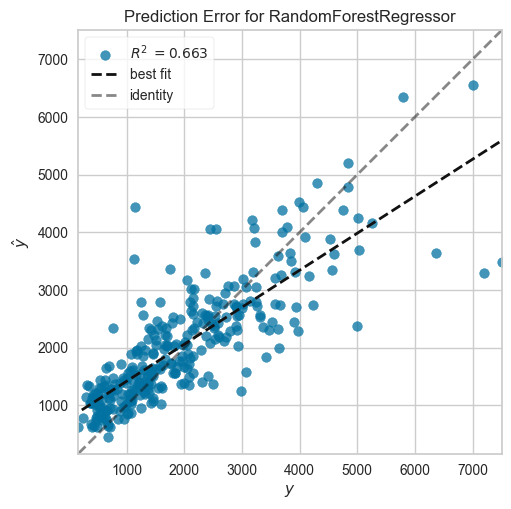

In [12]:
visualizer = PredictionError(pipeline)
visualizer.score(X_cal, y_cal)  # Evaluate the model on the test data
visualizer.show()
plt.show()

In [13]:
# calculate calibraion errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [14]:
# calculate quantile with final sample adjustment to ensure coverage
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.9533333333333334

In [15]:
#calculate q_hat on the calibration set
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)
q_yhat_cal

1510.5368878162737

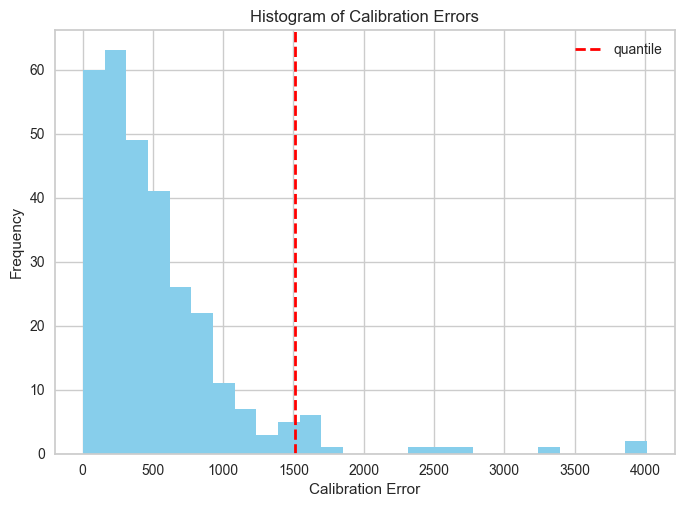

In [16]:
# Plot the histogram
plt.hist(y_cal_error, bins='auto', color='skyblue')

# Add a vertical line for the
plt.axvline(q_yhat_cal, color='red', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')
plt.show()

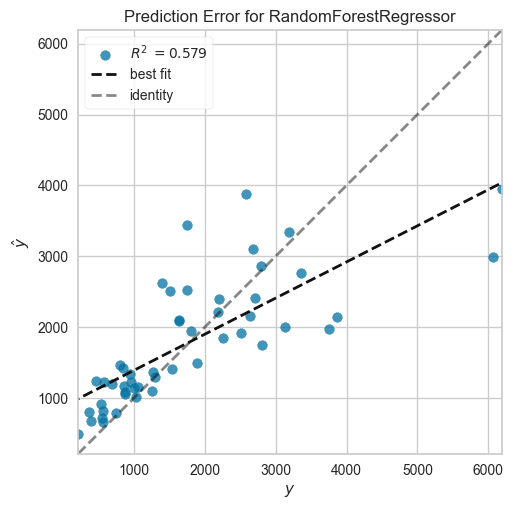

<Figure size 800x550 with 0 Axes>

In [17]:
visualizer = PredictionError(pipeline)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()
plt.savefig("prediction_error_test_data.png", bbox_inches="tight")
plt.show()

In [18]:
y_hat_test_lower = y_pred_test - q_yhat_cal
y_hat_test_upper = y_pred_test + q_yhat_cal

In [19]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

In [20]:
predict_df

,actual,predicted,lower_bound,upper_bound
0,953.718404,1227.498923,-283.037965,2738.035811
1,1296.963172,1301.143314,-209.393574,2811.680202
2,2262.298508,1843.831574,333.294686,3354.368461
3,3183.919430,3337.641269,1827.104381,4848.178157
4,2186.598908,2217.376993,706.840105,3727.913881
5,1894.104453,1491.003402,-19.533486,3001.540290
6,942.131505,1335.719593,-174.817295,2846.256480
7,866.147196,1078.688890,-431.847998,2589.225778
8,6189.762211,3948.393662,2437.856774,5458.930550
9,3133.792915,2007.223981,496.687093,3517.760869


In [21]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.9


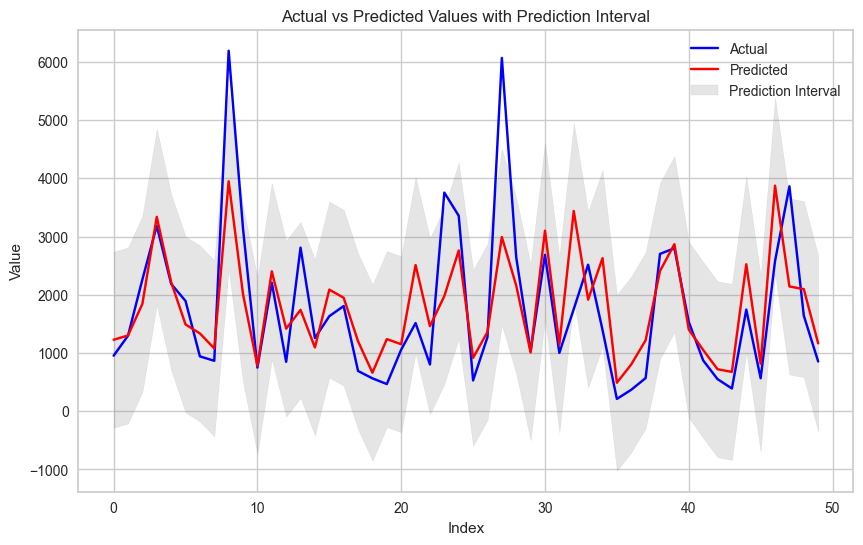

In [22]:
# Sort DataFrame by 'actual' values for smooth line plots

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(predict_df['actual'], label='Actual', color='blue')

# Plot predicted values
plt.plot(predict_df['predicted'], label='Predicted', color='red')

# Plot prediction intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Add the legend
plt.legend()

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')
plt.savefig("../results/conformal_prediction/actual_vs_predicted_with_interval.png", bbox_inches="tight")

# Show the plot
plt.show()


In [23]:
rmse = root_mean_squared_error(y_test, y_pred_test)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 846.061764394642


In [24]:
predict_df.to_csv("../results/conformal_prediction/coverage.csv", index=False)

## Save Model

In [25]:
joblib.dump(pipeline, "../models/pipeline.pkl")

['../models/pipeline.pkl']

# Save 95th percentile quantile error

In [26]:
data = {
    "q_yhat_cal": q_yhat_cal
}

In [27]:
with open("../models/q_yhat_calib.json", "w") as json_file:
    json.dump(data, json_file)